<a href="https://colab.research.google.com/github/yarusx/GLC/blob/glc/cats_breeds_0_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pathlib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q /content/drive/MyDrive/Cat.zip

In [ ]:
data_dir = pathlib.Path('/content/Cat')

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  class_names = ['egyptian_mau', 'siamese', 'birman', 'abyssinian', 'sphynx', 'british_shorthair', 'bombay', 'russian_blue', 'persian', 'ragdoll', 'maine_coon', 'bengal'],
  validation_split=0.2,
  subset="training",
  seed=51,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  class_names = ['egyptian_mau', 'siamese', 'birman', 'abyssinian', 'sphynx', 'british_shorthair', 'bombay', 'russian_blue', 'persian', 'ragdoll', 'maine_coon', 'bengal'],
  validation_split=0.2,
  subset="validation",
  seed=51,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2400 files belonging to 12 classes.
Using 1920 files for training.
Found 2400 files belonging to 12 classes.
Using 480 files for validation.


In [ ]:
class_names = train_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [ ]:
# val_batches = tf.data.experimental.cardinality(validation_dataset)
# test_dataset = validation_dataset.take(val_batches // 5)
# validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
# test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [ ]:
#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(37)
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(32, 37)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

15/15 [==============================] - 1s 44ms/step - loss: 4.3372 - accuracy: 0.0167
initial loss: 4.34
initial accuracy: 0.02


In [ ]:
initial_epochs = 1
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
val_acc = history.history['val_accuracy']

60/60 [==============================] - 6s 99ms/step - loss: 3.7018 - accuracy: 0.0771 - val_loss: 2.7470 - val_accuracy: 0.1688


In [ ]:
while np.mean(val_acc)*100 < 87.0:
  initial_epochs = 5
  history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)
  
  val_acc = history.history['val_accuracy']
  
try:
  !mkdir -p saved_model
except:
  pass

model.save('saved_model/cats')

!zip -r cats_breeds.zip saved_model/cats/

from google.colab import files
files.download("cats_breeds.zip")

In [ ]:
!unzip -q /content/drive/MyDrive/cats_breeds.zip
cats_model = tf.keras.models.load_model('/content/saved_model/cats')

In [ ]:
try:
  !mkdir -p saved_model
except:
  pass

cats_model.save('saved_model/cats')

!zip -r cats_breeds.zip saved_model/cats/

from google.colab import files
files.download("cats_breeds.zip")

In [ ]:
from keras.preprocessing.image import load_img, img_to_array

# load and prepare the image
def load_image(filename):
	# load the image
	img = load_img(filename, target_size=(160, 160))
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1, 160, 160, 3)
	return img

img = load_image('/content/drive/MyDrive/cat_1.jpeg')

In [ ]:
c_breeds = ['egyptian_mau', 'siamese', 'birman', 'abyssinian', 'sphynx', 'british_shorthair', 'bombay', 'russian_blue', 'persian', 'ragdoll', 'maine_coon', 'bengal']

In [ ]:
prediction = cats_model.predict(img, batch_size=None,)
prediction = tf.nn.softmax(prediction)
prediction = np.argmax(prediction, axis=1)
print(prediction)

[7]


Text(0.5, 1.0, 'russian_blue')

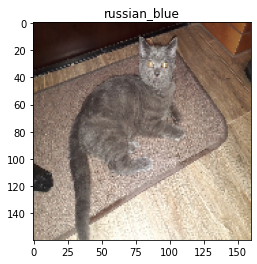

In [ ]:
plt.figure()
plt.imshow(img[0]/255)
plt.title(c_breeds[int(prediction)])

In [ ]:
# #Retrieve a batch of images from the test set
# image_batch, label_batch = test_dataset.as_numpy_iterator().next()
# predictions = model.predict_on_batch(image_batch)

# # Apply a sigmoid since our model returns logits
# predictions = tf.nn.softmax(predictions)
# #print(predictions.shape)
# predictions = np.argmax(predictions, axis=1)

# print('Predictions:\n', predictions)
# print('Labels:\n', label_batch)

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].astype("uint8"))
#   plt.title(class_names[predictions[i]])
#   plt.axis("off")